In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import geopandas as gpd
from p_tqdm import p_map
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature

/work/xinchenhe_umass_edu/.conda/envs/laketemp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
lakes_with_clz = pd.read_csv("../data/lakes_with_climate_zone.csv", index_col = 0).loc[cci_lake_list]
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes = pd.concat([cci_lakes, lakes_with_clz.loc[:,["climate_zone"]]], axis = 1)
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [3]:
train_stats_obs = pd.read_csv("../data/obs_stats_train.csv", index_col = 0)
val_stats_obs = pd.read_csv("../data/obs_stats_val.csv", index_col = 0)
total_stats_obs = pd.read_csv("../data/obs_stats_total.csv", index_col = 0)

In [4]:
### =============================== =====Calculate the stat differences ===========================================================

# Total period, only for observations
stat_diff_total = pd.DataFrame([], index = total_stats_obs.index)
stat_diff_total["obs_diff_mean"] = total_stats_obs["obs_cloud_mean"] - total_stats_obs["obs_mean"]
stat_diff_total["obs_diff_warmest_mean"] = total_stats_obs["obs_cloud_warmest_mean"] - total_stats_obs["obs_warmest_mean"]
stat_diff_total["obs_diff_coldest_mean"] = total_stats_obs["obs_cloud_coldest_mean"] - total_stats_obs["obs_coldest_mean"]
stat_diff_total["obs_diff_summer_mean"] = total_stats_obs["obs_cloud_summer_mean"] - total_stats_obs["obs_summer_mean"]
# create a geopandas dataframe
stats_gdf_total = gpd.GeoDataFrame(pd.concat([cci_lakes_gdf, stat_diff_total], axis = 1))

In [5]:
stats_gdf_total.describe()

,LAT CENTRE,LON CENTRE,MAX DISTANCE TO LAND (KM),LAT MIN BOX,LAT MAX BOX,LON MIN BOX,LON MAX BOX,obs_diff_mean,obs_diff_warmest_mean,obs_diff_coldest_mean,obs_diff_summer_mean
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,36.111069,-4.338783,4.405208,35.923326,36.293683,-4.604031,-4.075752,0.966496,0.190138,-0.026901,0.157769
std,30.143822,88.220572,5.427312,30.156539,30.137472,88.263515,88.186438,1.296098,0.305682,0.115034,0.388947
min,-54.548600,-178.512500,0.200000,-54.654200,-54.462500,-178.904200,-177.629200,-2.742787,-7.482140,-0.933122,-1.330947
25%,24.854900,-93.000700,2.200000,24.583350,25.037500,-93.329200,-92.750000,0.054146,0.019317,-0.013055,-0.004421
50%,46.116650,12.579200,3.100000,45.950000,46.354200,12.350000,12.675000,0.805998,0.133167,0.000000,0.006110
75%,57.334700,77.821525,4.700000,57.047950,57.622900,77.483300,78.185400,1.749572,0.316422,0.000000,0.292879
max,81.768100,177.195800,84.100000,81.595800,81.987500,176.945800,177.554200,6.380639,1.482680,1.079109,2.448443


In [6]:
stats_gdf_total.sort_values("obs_diff_warmest_mean").head(2)

,NAME,COUNTRY,LAT CENTRE,LON CENTRE,MAX DISTANCE TO LAND (KM),LAT MIN BOX,LAT MAX BOX,LON MIN BOX,LON MAX BOX,ID in GLOBOLAKES 1000 MASK,ID in CGLOPS MASK,climate_zone,geometry,obs_diff_mean,obs_diff_warmest_mean,obs_diff_coldest_mean,obs_diff_summer_mean
cci_lake_id,,,,,,,,,,,,,,,,,
2226,Khanskoye ozero,Russian Federation,46.2625,38.3458,3.8,46.1042,46.3458,38.2708,38.5375,2226;,NaN,Temperate,POINT (38.3458 46.2625),-0.083326,-7.482140,-0.159092,0.051988
435,ozero Pekulneyskoye,Russian Federation,62.6347,177.1958,7.1,62.5125,62.9042,176.9208,177.5542,NaN,435;,Continental,POINT (177.1958 62.6347),-0.660538,-0.334119,0.000000,-1.177268


In [7]:
# Remove 2226 because it was dried out and no warmest-month mean temperature
stats_gdf_total = stats_gdf_total.loc[stats_gdf_total.index != 2226]
stats_gdf_total

,NAME,COUNTRY,LAT CENTRE,LON CENTRE,MAX DISTANCE TO LAND (KM),LAT MIN BOX,LAT MAX BOX,LON MIN BOX,LON MAX BOX,ID in GLOBOLAKES 1000 MASK,ID in CGLOPS MASK,climate_zone,geometry,obs_diff_mean,obs_diff_warmest_mean,obs_diff_coldest_mean,obs_diff_summer_mean
cci_lake_id,,,,,,,,,,,,,,,,,
799,Hawizeh marshes,Iraq;Iran Islamic Republic of,31.3792,47.7236,1.0,31.2042,31.4292,47.6042,47.7792,799;,799;,Arid,POINT (47.7236 31.3792),2.434771,-0.021021,0.560106,-4.374010e-02
3114,loch Ness,United Kingdom,57.3792,-4.3597,1.2,57.1042,57.4542,-4.7125,-4.2958,3114;,NaN,Temperate,POINT (-4.3597 57.3792),-0.219303,0.496267,-0.172648,-1.126530e-01
7889,lough Melvin,Ireland;United Kingdom,54.4208,-8.1264,1.3,54.3625,54.4958,-8.2875,-8.0542,7889;,NaN,Temperate,POINT (-8.1264 54.4208),-0.449118,0.190328,-0.109317,-2.866298e-01
2516,loch Lomond,United Kingdom,56.0708,-4.5792,1.5,55.9708,56.3458,-4.7542,-4.4792,2516;,NaN,Temperate,POINT (-4.5792 56.0708),-0.248822,0.529307,-0.186868,-1.328558e-01
12262,loch Leven,United Kingdom,56.2042,-3.3792,1.5,56.1375,56.2625,-3.4542,-3.2958,12262;,NaN,Temperate,POINT (-3.3792 56.2042),-0.430521,0.342421,-0.095710,-2.736533e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,Shishmaref inlet and Ikpek lagoon and Cowpac...,United States,66.1736,-165.9792,7.1,65.7958,66.5792,-167.3042,-164.6458,NaN,473;,Continental,POINT (-165.9792 66.1736),-0.365742,0.043364,0.000000,-1.499820e-08
309,Zzzz,United States,41.0236,-113.5208,7.6,40.6958,41.3375,-113.6792,-113.2542,NaN,309;,Arid,POINT (-113.5208 41.0236),4.873278,-0.047870,0.000815,-7.809960e-02
141,Baird inlet and Kaghasuk lake,United States,60.7125,-163.6097,9.2,60.5292,61.0458,-165.0625,-163.3708,NaN,141;,Continental,POINT (-163.6097 60.7125),-1.568336,0.462195,0.000000,-5.166073e-04


# 1. Tmean

In [8]:
# fig = plt.figure(figsize=(10, 3))  # Wider figure
# nt_proj = ccrs.PlateCarree()

# # Convert projections
# stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# # Define gridspec layout: One row, two columns
# gs = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.4])

# # Geographical distribution of Bias (Left plot)
# ax1 = fig.add_subplot(gs[0, 0], projection=nt_proj)
# ax1.add_feature(cfeature.OCEAN, zorder=0)
# ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
# ax1.set_global()
# gl1 = ax1.gridlines(crs=nt_proj, draw_labels=True)
# gl1.top_labels = False
# gl1.right_labels = False

# # Plot Bias on the map
# stats_gdf_total.dropna(subset=["obs_diff_mean"]).plot(
#     column="obs_diff_mean",
#     markersize=10,
#     cmap="bwr",
#     vmin=-3,
#     vmax=3,
#     legend_kwds={'label': '$Bias (^\\circ C)$',
#                  "orientation": "vertical",
#                  "extend": "both",
#                  "shrink": 0.75,
#                  "pad": 0.1},
#     legend=True,
#     ax=ax1
# )

# # Histogram (Right plot)
# ax2 = fig.add_subplot(gs[0, 1])
# sns.histplot(x="obs_diff_mean", data=stats_gdf_total, ax=ax2, stat = "proportion", bins = 20)
# ax2.set_ylabel("Proportion")
# ax2.set_xlabel("$Bias (^{\\circ}C)$")

# # Add centered row title above both axes
# fig.text(0.55, 0.97, "(a) Cloud bias in observed Tmean", ha='center', va='center', fontsize=12, fontweight='bold')

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
# plt.show()

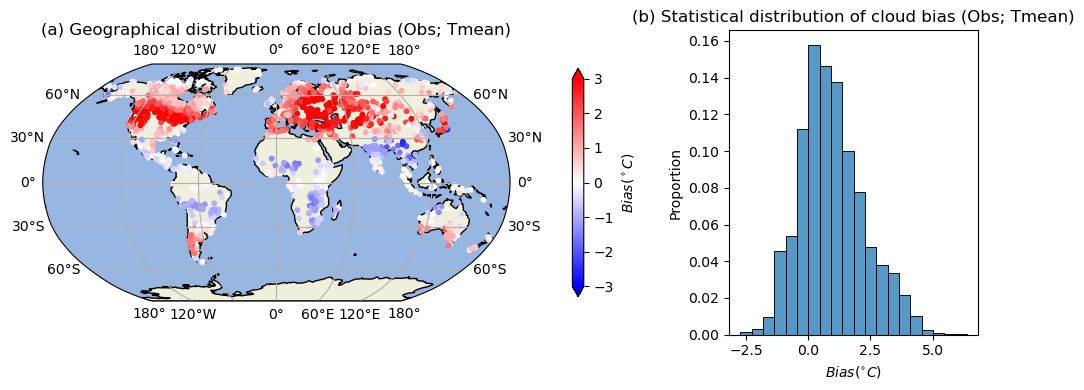

In [8]:
fig = plt.figure(figsize=(10, 4))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# Convert projections
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# Define gridspec layout: One row with two columns
gs = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.4])

# Geographical distribution of Bias (Left plot)
ax1 = fig.add_subplot(gs[0, 0], projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax1.set_title("(a) Geographical distribution of cloud bias (Obs; Tmean)")
ax1.set_global()
ax1.gridlines(draw_labels = True)
# Plot Bias on the map
stats_gdf_total.dropna(subset=["obs_diff_mean"]).plot(
    column="obs_diff_mean",
    markersize=10,
    cmap="bwr",
    vmin=-3,
    vmax=3,
    legend_kwds={'label': '$Bias (^\\circ C)$',
                 "orientation": "vertical",
                 "extend": "both",
                 "shrink": 0.75,
                 "pad": 0.1},
    legend=True,
    ax=ax1
)

# Histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x = "obs_diff_mean", data = stats_gdf_total, ax = ax2, stat = "proportion", bins = 20)
ax2.set_title("(b) Statistical distribution of cloud bias (Obs; Tmean)")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("$Bias (^{\\circ}C)$")

plt.tight_layout()
plt.show()

In [9]:
# fig.savefig("../figs/bias_observations_tmean.png", dpi = 300, bbox_inches='tight')

# 2. Twarm

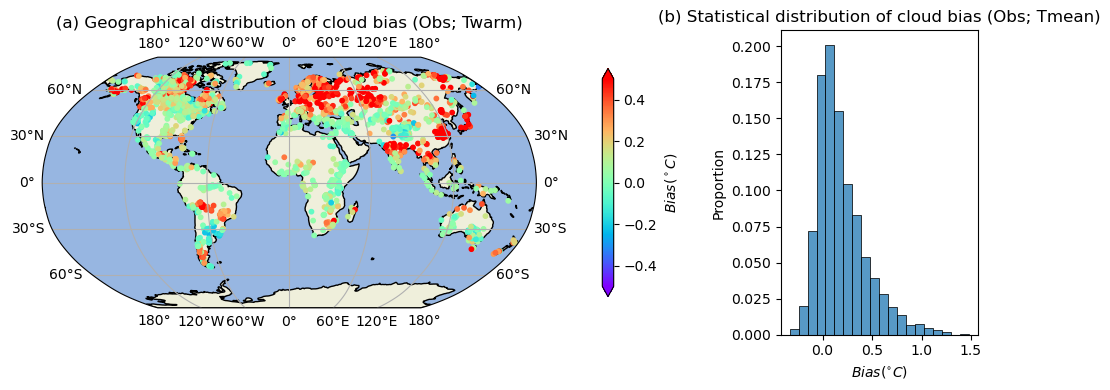

In [9]:
fig = plt.figure(figsize=(10, 4))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# Convert projections
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# fig.suptitle("Bias of Twarm in synthetic observations", y=0.95)

# Define gridspec layout: One row with two columns
gs = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.3])

# Geographical distribution of Bias (Left plot)
ax1 = fig.add_subplot(gs[0, 0], projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax1.set_title("(a) Geographical distribution of cloud bias (Obs; Twarm)")
ax1.set_global()
ax1.gridlines(draw_labels=True)

# Plot Bias on the map
stats_gdf_total.dropna(subset=["obs_diff_warmest_mean"]).plot(
    column="obs_diff_warmest_mean",
    markersize=10,
    cmap="rainbow",
    vmin=-0.5,
    vmax=0.5,
    legend_kwds={'label': '$Bias (^\\circ C)$',
                 "orientation": "vertical",
                 "extend": "both",
                 "shrink": 0.75,
                 "pad": 0.1},
    legend=True,
    ax=ax1
)

# Scatter plot for Latitude vs Bias (Right plot)
# ax2 = fig.add_subplot(gs[0, 1])
# sns.scatterplot(x="obs_diff_warmest_mean", y="LAT CENTRE", data=stats_gdf_total, ax=ax2)
# ax2.set_title("(b) Latitude VS Cloud bias (Obs; Twarm)")
# ax2.set_ylabel("Latitude")
# ax2.set_xlabel("$Bias (^{\\circ}C)$")
# ax2.axvline(x=0, linestyle="--", color="red", linewidth=1.5)

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x = "obs_diff_warmest_mean", data = stats_gdf_total, ax = ax2, stat = "proportion", bins = 20)
ax2.set_title("(b) Statistical distribution of cloud bias (Obs; Tmean)")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("$Bias (^{\\circ}C)$")

plt.tight_layout()
plt.show()

In [12]:
# fig.savefig("../figs/bias_observations_twarm.png", dpi = 300, bbox_inches='tight')

In [13]:
# fig = plt.figure(figsize=(8, 8))
# nt_proj = ccrs.Mollweide()

# # Convert projections
# stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# fig.suptitle("Bias of Twarm in synthetic observations", y = 0.9)

# # Define gridspec layout
# gs = gridspec.GridSpec(2, 2, width_ratios=[1.0, 1.0], height_ratios=[1, 0.6])

# # Geographical distribution of $Bias_{Tmean}^{obs}$ (Moved from a1 → a2)
# ax1 = fig.add_subplot(gs[0, :], projection=nt_proj)
# ax1.add_feature(cfeature.OCEAN, zorder=0)
# ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
# ax1.set_title("(a) Geographical distribution")
# ax1.set_global()
# ax1.gridlines(draw_labels=True,)

# # Plot $Bias_{Tmean}^{obs}$
# stats_gdf_total.dropna(subset=["obs_diff_warmest_mean"]).plot(
#     column="obs_diff_warmest_mean",
#     markersize=10,
#     cmap="bwr",
#     vmin=-0.5,
#     vmax=1,
#     legend_kwds={'label': '$Bias (^\\circ C)$',
#                  "orientation": "vertical",
#                  "extend": "both",
#                  "shrink": 0.75,
#                   "pad": 0.1},
#     legend=True,
#     ax=ax1
# )

# # Histogram for Tmean (Moved from a3 → a1)
# ax2 = fig.add_subplot(gs[1, 0])
# sns.histplot(stats_gdf_total.obs_diff_warmest_mean, stat="proportion", bins=20, ax=ax2)
# ax2.set_ylabel("Probability Density")
# ax2.set_xlabel("$Bias (^\\circ C)$")
# ax2.set_title("(b) Statistical distribution")

# # Box plot across different climate zones (Moved from a2 → a3)
# ax3 = fig.add_subplot(gs[1, 1])
# sns.scatterplot(x="obs_diff_warmest_mean", y="LAT CENTRE", data=stats_gdf_total, ax=ax3)
# ax3.set_title("(c) Latitude VS Bias")
# ax3.set_ylabel("Latitude")
# ax3.set_xlabel("$Bias (^{\\circ}C)$")
# ax3.axvline(x=0, linestyle="--", color="red", linewidth=1.5)


# plt.tight_layout()
# plt.show()

# Summer mean

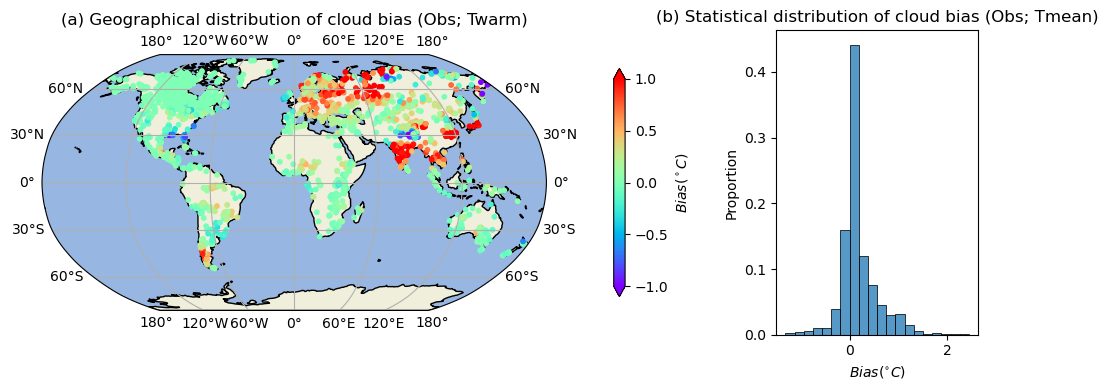

In [11]:
fig = plt.figure(figsize=(10, 4))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# Convert projections
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# fig.suptitle("Bias of Twarm in synthetic observations", y=0.95)

# Define gridspec layout: One row with two columns
gs = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.3])

# Geographical distribution of Bias (Left plot)
ax1 = fig.add_subplot(gs[0, 0], projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax1.set_title("(a) Geographical distribution of cloud bias (Obs; Twarm)")
ax1.set_global()
ax1.gridlines(draw_labels=True)

# Plot Bias on the map
stats_gdf_total.dropna(subset=["obs_diff_summer_mean"]).plot(
    column="obs_diff_summer_mean",
    markersize=10,
    cmap="rainbow",
    vmin=-1,
    vmax=1,
    legend_kwds={'label': '$Bias (^\\circ C)$',
                 "orientation": "vertical",
                 "extend": "both",
                 "shrink": 0.75,
                 "pad": 0.1},
    legend=True,
    ax=ax1
)

# Scatter plot for Latitude vs Bias (Right plot)
# ax2 = fig.add_subplot(gs[0, 1])
# sns.scatterplot(x="obs_diff_warmest_mean", y="LAT CENTRE", data=stats_gdf_total, ax=ax2)
# ax2.set_title("(b) Latitude VS Cloud bias (Obs; Twarm)")
# ax2.set_ylabel("Latitude")
# ax2.set_xlabel("$Bias (^{\\circ}C)$")
# ax2.axvline(x=0, linestyle="--", color="red", linewidth=1.5)

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x = "obs_diff_summer_mean", data = stats_gdf_total, ax = ax2, stat = "proportion", bins = 20)
ax2.set_title("(b) Statistical distribution of cloud bias (Obs; Tmean)")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("$Bias (^{\\circ}C)$")

plt.tight_layout()
plt.show()

# Merge

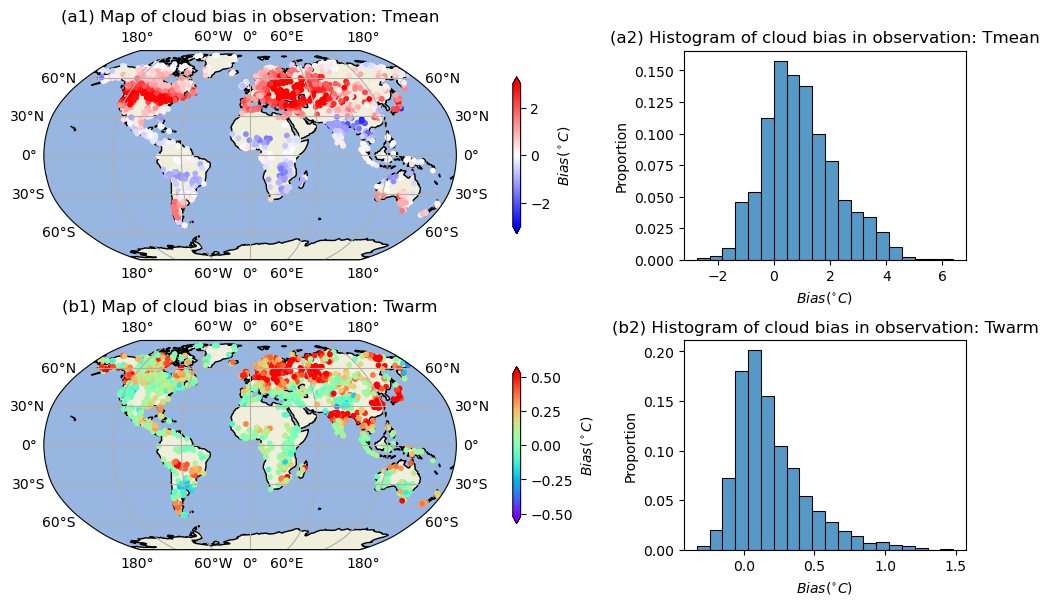

In [14]:
# Set up the projection and transform GeoDataFrame
nt_proj = ccrs.Robinson()
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# Create a vertical layout: 2 rows, 2 columns
fig = plt.figure(figsize=(10, 6))  # Taller figure
gs = gridspec.GridSpec(2, 2, width_ratios=[1.0, 0.5], height_ratios=[1, 1])

# === Row 1: Tmean ===
# Map
ax1 = fig.add_subplot(gs[0, 0], projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax1.set_title("(a1) Map of cloud bias in observation: Tmean")
ax1.set_global()
ax1.gridlines(draw_labels=True)
stats_gdf_total.dropna(subset=["obs_diff_mean"]).plot(
    column="obs_diff_mean",
    markersize=10,
    cmap="bwr",
    vmin=-3,
    vmax=3,
    legend_kwds={'label': '$Bias (^\\circ C)$', "orientation": "vertical", "extend": "both", "shrink": 0.75, "pad": 0.1},
    legend=True,
    ax=ax1
)

# Histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x="obs_diff_mean", data=stats_gdf_total, ax=ax2, stat="proportion", bins=20)
ax2.set_title("(a2) Histogram of cloud bias in observation: Tmean")
ax2.set_ylabel("Proportion")
ax2.set_xlabel("$Bias (^{\\circ}C)$")

# === Row 2: Twarm ===
# Map
ax3 = fig.add_subplot(gs[1, 0], projection=nt_proj)
ax3.add_feature(cfeature.OCEAN, zorder=0)
ax3.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax3.set_title("(b1) Map of cloud bias in observation: Twarm")
ax3.set_global()
ax3.gridlines(draw_labels=True)
stats_gdf_total.dropna(subset=["obs_diff_warmest_mean"]).plot(
    column="obs_diff_warmest_mean",
    markersize=10,
    cmap="rainbow",
    vmin=-0.52,
    vmax=0.52,
    legend_kwds={'label': '$Bias (^\\circ C)$', "orientation": "vertical", "extend": "both", "shrink": 0.75, "pad": 0.1},
    legend=True,
    ax=ax3
)

# Histogram
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(x="obs_diff_warmest_mean", data=stats_gdf_total, ax=ax4, stat="proportion", bins=20)
ax4.set_title("(b2) Histogram of cloud bias in observation: Twarm")
ax4.set_ylabel("Proportion")
ax4.set_xlabel("$Bias (^{\\circ}C)$")

# Final layout
plt.tight_layout()
plt.show()

In [15]:
# fig.savefig("../figs/bias_observations.png", dpi = 300, bbox_inches='tight')

# Plot Tmean with cloud occurrence

In [8]:
total_period = pd.date_range("2003-01-01", "2023-12-31")

# change here to replace with cloud gapped lake surface water temperature for calibration
df_tw = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv", index_col=0, 
                    parse_dates=True).loc[total_period, cci_lake_list.astype(str)]
df_tw_cloud = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp_cloud.csv", index_col=0, 
                    parse_dates=True).loc[total_period, cci_lake_list.astype(str)]

In [9]:
# cloud frequency
cloud_freq_mean = 1 - (df_tw_cloud.groupby([df_tw_cloud.index.year, df_tw_cloud.index.month]).count()/df_tw.groupby([df_tw.index.year, df_tw.index.month]).count()).reset_index().groupby("level_1").mean()
cloud_freq_90 = 1 - (df_tw_cloud.groupby([df_tw_cloud.index.year, df_tw_cloud.index.month]).count()/df_tw.groupby([df_tw.index.year, df_tw.index.month]).count()).reset_index().groupby("level_1").quantile(q = 0.90)
cloud_freq_10 = 1 - (df_tw_cloud.groupby([df_tw_cloud.index.year, df_tw_cloud.index.month]).count()/df_tw.groupby([df_tw.index.year, df_tw.index.month]).count()).reset_index().groupby("level_1").quantile(q = 0.10)

# monthly temperature
monthly_temp_mean = df_tw.groupby([df_tw.index.year,df_tw.index.month ]).mean().reset_index().groupby("level_1").mean()
monthly_temp_90 = df_tw.groupby([df_tw.index.year,df_tw.index.month ]).mean().reset_index().groupby("level_1").quantile(q = 0.90)
monthly_temp_10 = df_tw.groupby([df_tw.index.year,df_tw.index.month ]).mean().reset_index().groupby("level_1").quantile(q = 0.10)

In [10]:
def plot_time_series(ax, ax_twin, lake_id, title_label = "a"):
    ax.fill_between(cloud_freq_mean.index, cloud_freq_10.loc[:, lake_id], cloud_freq_90.loc[:, lake_id], alpha = 0.5, color = "blue")
    ax.plot(cloud_freq_mean.loc[:, lake_id], color = "blue", label = "monthly mean cloud frequency")
    ax_twin.fill_between(monthly_temp_mean.index, monthly_temp_10.loc[:, lake_id], monthly_temp_90.loc[:, lake_id], alpha = 0.5, color = "red")
    ax_twin.plot(monthly_temp_mean.loc[:, lake_id], color = "red", label = "monthly mean temperature")
    ax.set_ylabel("Cloud frequency")
    ax_twin.set_ylabel("Monthly mean temperature")
    ax.legend(loc = "upper left")
    ax_twin.legend(loc = "upper right")
    ax.set_ylim([0, 1])
    ax.set_title(f"({title_label})" + f" {cci_lakes_gdf.loc[int(lake_id), "NAME"]}, {cci_lakes_gdf.loc[int(lake_id), "COUNTRY"]}".title() + f"; cci_id = {lake_id}; ({cci_lakes_gdf.loc[int(lake_id), "LON CENTRE"]:.3f}, {cci_lakes_gdf.loc[int(lake_id), "LAT CENTRE"]:.3f})")
    ax.set_xlabel("Month")

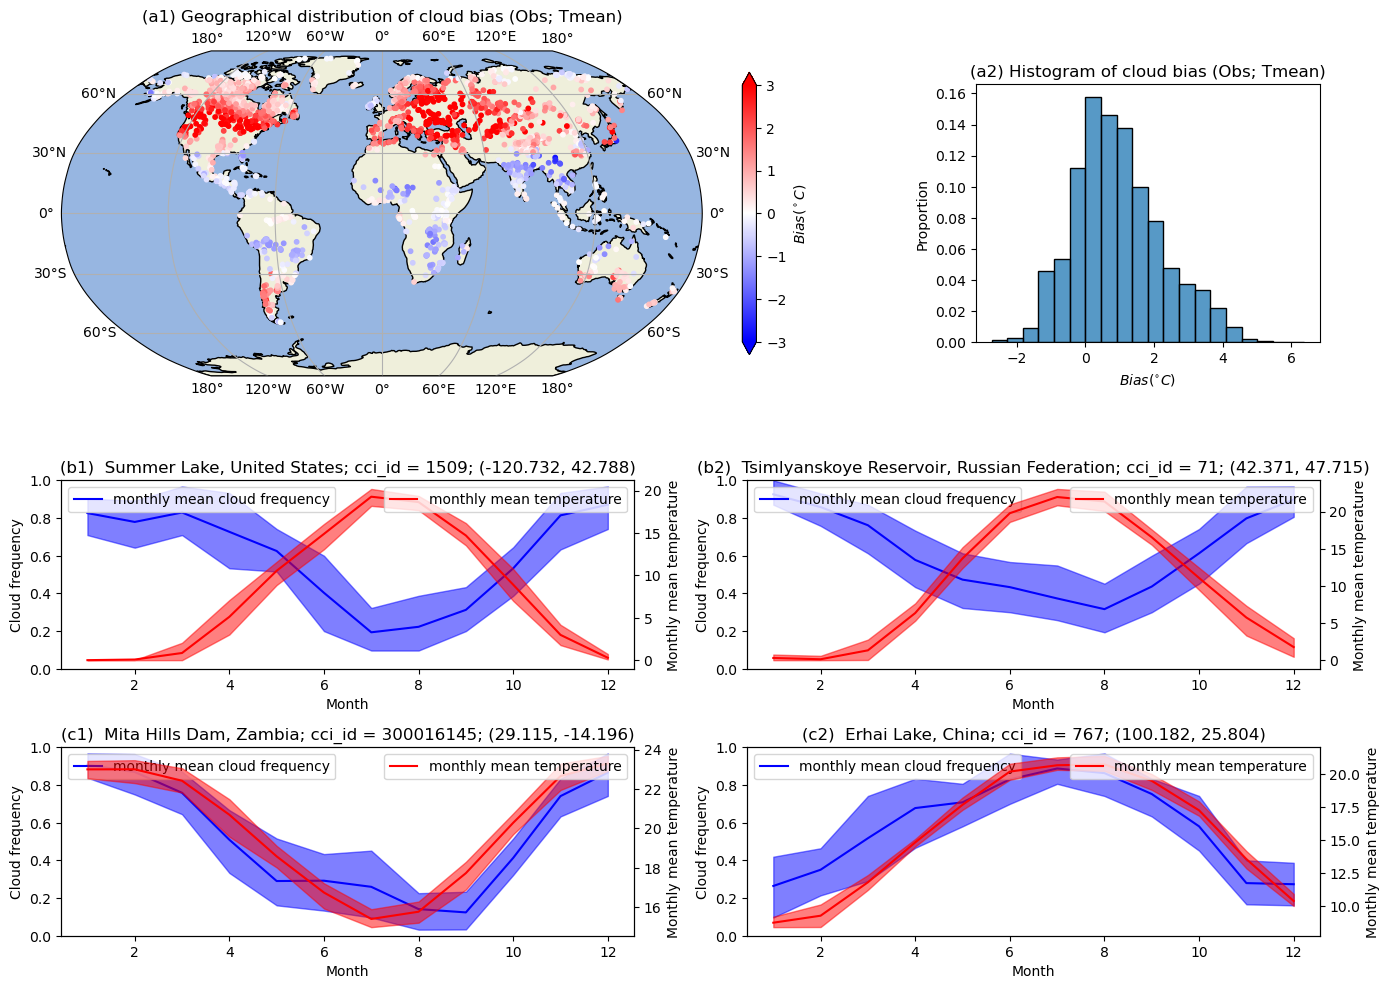

In [13]:
fig = plt.figure(figsize=(14, 10))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# Convert projections
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# Define gridspec layout: One row with two columns
gs = gridspec.GridSpec(3, 6, height_ratios=[1, 0.5, 0.5])

# === Row 1: Geographical distribution and histogram (now b1, b2)
ax11 = fig.add_subplot(gs[0, :4], projection=nt_proj)
ax11.add_feature(cfeature.OCEAN, zorder=0)
ax11.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax11.set_title("(a1) Geographical distribution of cloud bias (Obs; Tmean)")
ax11.set_global()
ax11.gridlines(draw_labels=True)

# Plot Bias on the map
stats_gdf_total.dropna(subset=["obs_diff_mean"]).plot(
    column="obs_diff_mean",
    markersize=10,
    cmap="bwr",
    vmin=-3,
    vmax=3,
    legend_kwds={
        'label': '$Bias (^\\circ C)$',
        "orientation": "vertical",
        "extend": "both",
        "shrink": 0.75,
        "pad": 0.05
    },
    legend=True,
    ax=ax11
)

ax12 = fig.add_subplot(gs[0, 4:])
sns.histplot(x="obs_diff_mean", data=stats_gdf_total, ax=ax12, stat="proportion", bins=20)
ax12.set_title("(a2) Histogram of cloud bias (Obs; Tmean)")
ax12.set_ylabel("Proportion")
ax12.set_xlabel("$Bias (^{\\circ}C)$")
ax12.set_box_aspect(0.75)

# === Row 2: Time series plots (originally a1, a2 → now b1, b2)
ax21 = fig.add_subplot(gs[1, :3])
plot_time_series(ax21, ax21.twinx(), "1509", title_label="b1")

ax22 = fig.add_subplot(gs[1, 3:])
plot_time_series(ax22, ax22.twinx(), "71", title_label="b2")

# === Row 3: Additional time series plots (unchanged)
ax31 = fig.add_subplot(gs[2, :3])
plot_time_series(ax31, ax31.twinx(), "300016145", title_label="c1")

ax32 = fig.add_subplot(gs[2, 3:])
plot_time_series(ax32, ax32.twinx(), "767", title_label="c2")

plt.tight_layout()
plt.show()

In [14]:
fig.savefig("../figs/bias_observations_tmean.png", dpi = 300, bbox_inches='tight')